In [1]:
import os
os.environ['HTTP_PROXY'] = "http://127.0.0.1:10809"
os.environ['HTTPS_PROXY'] = "http://127.0.0.1:10809"

In [2]:
import ee
import geemap
Map = geemap.Map()
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [3]:
# 输入研究区的shp文件所在路径
wuhan_shp ="D:/NDVI_exercise/wuhan/wuhanregion.shpe"
# shp 转 ee 
wuhan_ee = geemap.shp_to_ee(wuhan_shp)
# 添加到layer
# Map.addLayer(wuhan_ee,{},"wuhan1+8")
Map.centerObject(wuhan_ee,7)   # 设置以研究区居中

In [13]:
# JRC_permanent_water = []
all_accuracy = []
kappa = []

# landsat 7 可用年份为1999-2020

In [14]:
def cloudMaskL457(image):
    qa = image.select('pixel_qa')
    # If the cloud bit (5) is set and the cloud confidence (7) is high
    # or the cloud shadow bit is set (3), then it's a bad pixel.
    cloud = qa.bitwiseAnd(1 << 5).And(qa.bitwiseAnd(1 << 7)).Or(qa.bitwiseAnd(1 << 3))
    # Remove edge pixels that don't occur in all bands
    mask2 = image.mask().reduce(ee.Reducer.min())
    return image.updateMask(cloud.Not()).updateMask(mask2)

# 可视化参数设置
vis_params = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 3000,
  'gamma': 1.4,
}

def NDVI(image):
    ndvi=image.normalizedDifference(['B4', 'B3']).rename('NDVI')  
    return image.addBands(ndvi)

def mNDWI(image):
    mndwi=image.normalizedDifference(['B2', 'B5']).rename("mNDWI")
    return image.addBands(mndwi)

# Use these bands for prediction.
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']
# 分类标签
label = 'waterclass'

In [15]:
# 可用年份为2010-2020
# year = 2018
# month = 4
# 定义一些变量
days_31 = [1,3,5,7,8,10,12]
days_30 = [4,6,9,11]
days_28 = [2]
for year in range(2010,2014,1):
    landsat_images = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR') \
        .filterBounds(wuhan_ee) \
        .filterDate('{}-01-01'.format(year), '{}-12-31'.format(year)) \
        .map(cloudMaskL457) \
        .map(NDVI) \
        .map(mNDWI)
    #合并
    wuhan_landsat7 = landsat_images.qualityMosaic('NDVI').clip(wuhan_ee)
    Map.addLayer(wuhan_landsat7,vis_params,"wuhan")
    # 当mNDWI > EVI时
    wuhan_mNDWI_NDVI = wuhan_landsat7.select('mNDWI').gt(wuhan_landsat7.select('NDVI'))
    wuhan_water = wuhan_mNDWI_NDVI.select('mNDWI').rename('waterclass')

    # Make the training dataset.
    points = wuhan_water.sample(**{
        'region': wuhan_ee,
        'scale': 30,
        'numPixels': 1000,
        'seed': 0,
        'geometries': True  # Set this to False to ignore geometries
    })

    # Overlay the points on the imagery to get training.
    sample_point = wuhan_landsat7.select(bands).sampleRegions(**{
        'collection': points,
        'properties': [label],
        'scale': 30
    })

    # 在training要素集中增加一个random属性，值为0到1的随机数
    withRandom = sample_point.randomColumn('random')

    #把生成随机数大于0.7的分成测试数据，否则为训练数据。这样可以把数据分成两份
    split = 0.7
    trainingPartition = withRandom.filter(ee.Filter.lt('random', split))
    testingPartition = withRandom.filter(ee.Filter.gte('random', split))

    # 利用70%数据随机森林进行训练
    trainedClassifier = ee.Classifier.smileRandomForest(20).train(trainingPartition,label,bands)
    #对Landsat-8进行分类
    result=wuhan_landsat7.select(bands).classify(trainedClassifier)
    Map.addLayer(result,{'min':0,'max':1,'palette': ['white','blue']},'RF_water')

    water = result.eq(1).selfMask().multiply(ee.Image.pixelArea()).divide(1e6)
    areas = water.reduceRegion(**{
        'reducer': ee.Reducer.sum(),
        'geometry': wuhan_ee.geometry(),
        'scale': 30,
        'maxPixels': 1e14
    })
#     JRC_permanent_water.append(areas.get('classification').getInfo())
#     print('{} year:{}'.format(year,areas.get('classification').getInfo()))
    # 使用JRC做验证
    JRC_wuhan_water = ee.Image("JRC/GSW1_2/YearlyHistory/{}".format(year)).clip(wuhan_ee)
    JRC_water = JRC_wuhan_water.gt(2).select("waterClass").rename('waterclass')
    JRC_points = JRC_water.sample(**{
        'region': wuhan_ee,
        'scale': 30,
        'numPixels': 3000,
        'seed': 0,
        'geometries': True  # Set this to False to ignore geometries
    })
    # Overlay the points on the imagery to get training.
    JRC_sample_point = wuhan_landsat7.select(bands).sampleRegions(**{
        'collection': JRC_points,
        'properties': [label],
        'scale': 30
    })
#     print(withRandom.first().getInfo())
    validated = JRC_sample_point.classify(trainedClassifier)

    test_accuracy = validated.errorMatrix('waterclass', 'classification')
    all_accuracy.append(test_accuracy.accuracy().getInfo())
    kappa.append(test_accuracy.kappa().getInfo())
    print('{}year,accuracy:{}'.format(year,test_accuracy.accuracy().getInfo()))
    print('{}year,kappa:{}'.format(year,test_accuracy.kappa().getInfo()))
#     print('producersAccuracy:',test_accuracy.producersAccuracy().getInfo())
#     print('consumersAccuracy:',test_accuracy.consumersAccuracy().getInfo())

2010year,accuracy:0.8396094839609484
2010year,kappa:0.6658561789556865
2011year,accuracy:0.8577405857740585
2011year,kappa:0.6937591075825335
2012year,accuracy:0.8716875871687587
2012year,kappa:0.727513817632042
2013year,accuracy:0.8898186889818689
2013year,kappa:0.7621311317070303


# landsat 8 可用年份为2014-2020

In [16]:
# 去云掩膜函数
def maskL8sr(image):
  # Bits 3 and 5 are cloud shadow and cloud, respectively.
  cloudShadowBitMask = (1 << 3)
  cloudsBitMask = (1 << 5)
  # Get the pixel QA band.
  qa = image.select('pixel_qa')
  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                 .And(qa.bitwiseAnd(cloudsBitMask).eq(0))
  return image.updateMask(mask)

# 可视化参数设置
vis_params = {
  'bands': ['B5', 'B4', 'B3'],
  'min': 0,
  'max': 3000,
  'gamma': 1.4,
}

def NDVI(image):
    ndvi=image.normalizedDifference(['B5', 'B4']).rename('NDVI')  
    return image.addBands(ndvi)

def mNDWI(image):
    mndwi=image.normalizedDifference(['B3', 'B6']).rename("mNDWI")
    return image.addBands(mndwi)

# Use these bands for prediction.
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']
# 分类标签
label = 'waterclass'

In [18]:
# 可用年份为2014-2020
# Year = 2018
# month = 4
# 定义一些变量
for year in range(2014,2019,1):
    landsat_images = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
        .filterBounds(wuhan_ee) \
        .filterDate('{}-01-01'.format(year), '{}-12-31'.format(year)) \
        .map(maskL8sr) \
        .map(NDVI) \
        .map(mNDWI)
    #合并
    wuhan_landsat8 = landsat_images.qualityMosaic('NDVI').clip(wuhan_ee)
    Map.addLayer(wuhan_landsat8,vis_params,"wuhan")
    # 当mNDWI > EVI时
    wuhan_mNDWI_NDVI = wuhan_landsat8.select('mNDWI').gt(wuhan_landsat8.select('NDVI'))
    wuhan_water = wuhan_mNDWI_NDVI.select('mNDWI').rename('waterclass')

    # Make the training dataset.
    points = wuhan_water.sample(**{
        'region': wuhan_ee,
        'scale': 30,
        'numPixels': 1000,
        'seed': 0,
        'geometries': True  # Set this to False to ignore geometries
    })

    # Overlay the points on the imagery to get training.
    sample_point = wuhan_landsat8.select(bands).sampleRegions(**{
        'collection': points,
        'properties': [label],
        'scale': 30
    })

    # 在training要素集中增加一个random属性，值为0到1的随机数
    withRandom = sample_point.randomColumn('random')

    #把生成随机数大于0.7的分成测试数据，否则为训练数据。这样可以把数据分成两份
    split = 0.7
    trainingPartition = withRandom.filter(ee.Filter.lt('random', split))
    testingPartition = withRandom.filter(ee.Filter.gte('random', split))

    # 利用70%数据随机森林进行训练
    trainedClassifier = ee.Classifier.smileRandomForest(20).train(trainingPartition,label,bands)
    #对Landsat-8进行分类
    result=wuhan_landsat8.select(bands).classify(trainedClassifier)
    Map.addLayer(result,{'min':0,'max':1,'palette': ['white','blue']},'RF_water')

    water = result.eq(1).selfMask().multiply(ee.Image.pixelArea()).divide(1e6)
    areas = water.reduceRegion(**{
        'reducer': ee.Reducer.sum(),
        'geometry': wuhan_ee.geometry(),
        'scale': 30,
        'maxPixels': 1e14
    })
    # JRC_permanent_water.append(areas.get('classification').getInfo())
    # print('{} year:{}'.format(year,areas.get('classification').getInfo()))
    # 使用JRC做验证
    JRC_wuhan_water = ee.Image("JRC/GSW1_2/YearlyHistory/{}".format(year)).clip(wuhan_ee)
    JRC_water = JRC_wuhan_water.gt(2).select("waterClass").rename('waterclass')
    JRC_points = JRC_water.sample(**{
        'region': wuhan_ee,
        'scale': 30,
        'numPixels': 3000,
        'seed': 0,
        'geometries': True  # Set this to False to ignore geometries
    })
    # Overlay the points on the imagery to get training.
    JRC_sample_point = wuhan_landsat8.select(bands).sampleRegions(**{
        'collection': JRC_points,
        'properties': [label],
        'scale': 30
    })
#     print(withRandom.first().getInfo())
    validated = JRC_sample_point.classify(trainedClassifier)

    test_accuracy = validated.errorMatrix('waterclass', 'classification')
    all_accuracy.append(test_accuracy.accuracy().getInfo())
    kappa.append(test_accuracy.kappa().getInfo())
    print('{}year,accuracy:{}'.format(year,test_accuracy.accuracy().getInfo()))
    print('{}year,kappa:{}'.format(year,test_accuracy.kappa().getInfo()))
#     print('producersAccuracy:',test_accuracy.producersAccuracy().getInfo())
#     print('consumersAccuracy:',test_accuracy.consumersAccuracy().getInfo())

2014year,accuracy:0.8786610878661087
2014year,kappa:0.7194898753018522
2015year,accuracy:0.8880918220946915
2015year,kappa:0.7580205811138014
2016year,accuracy:0.8890449438202247
2016year,kappa:0.7553924297244642
2017year,accuracy:0.8890469416785206
2017year,kappa:0.7616161791813028
2018year,accuracy:0.9017094017094017
2018year,kappa:0.7866186201002635


# 结果

In [19]:
print(all_accuracy)
print(kappa)

[0.8396094839609484, 0.8577405857740585, 0.8716875871687587, 0.8898186889818689, 0.8786610878661087, 0.8880918220946915, 0.8890449438202247, 0.8890469416785206, 0.9017094017094017]
[0.6658561789556865, 0.6937591075825335, 0.727513817632042, 0.7621311317070303, 0.7194898753018522, 0.7580205811138014, 0.7553924297244642, 0.7616161791813028, 0.7866186201002635]


使用JRC数据集验证

In [ ]:
JRC_wuhan_water = ee.Image("JRC/GSW1_2/YearlyHistory/{}".format(Year)).clip(wuhan_ee)
JRC_water = JRC_wuhan_water.gt(2).select("waterClass").rename('waterclass')
JRC_points = JRC_water.sample(**{
    'region': wuhan_ee,
    'scale': 30,
    'numPixels': 3000,
    'seed': 0,
    'geometries': True  # Set this to False to ignore geometries
})

# print(points.first().getInfo())
# Overlay the points on the imagery to get training.
JRC_sample_point = wuhan_landsat8.select(bands).sampleRegions(**{
  'collection': JRC_points,
  'properties': [label],
  'scale': 30
})
print(withRandom.first().getInfo())
validated = JRC_sample_point.classify(trainedClassifier)

test_accuracy = validated.errorMatrix('waterclass', 'classification')
print('accuracy:',test_accuracy.accuracy().getInfo())
print('kappa:',test_accuracy.kappa().getInfo())
print('producersAccuracy:',test_accuracy.producersAccuracy().getInfo())
print('consumersAccuracy:',test_accuracy.consumersAccuracy().getInfo())

# 绘图

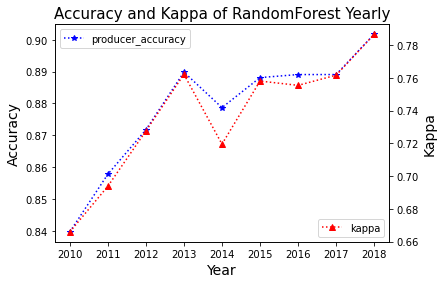

In [29]:
import matplotlib.pyplot as plt
import numpy as np
year = np.arange(2010,2019,1)
# plot permanent water and seasonal water(折线图)
plt.title("Accuracy and Kappa of RandomForest Yearly", fontsize=15)
plt.plot(year,all_accuracy,'*:b' ,label = 'producer_accuracy')
plt.xlabel("Year", fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc = 'upper left')
plt.twinx()
plt.plot(year,kappa,'^:r',label='kappa')
plt.ylabel('Kappa', fontsize=14)
plt.legend(loc = 'lower right')
plt.show()


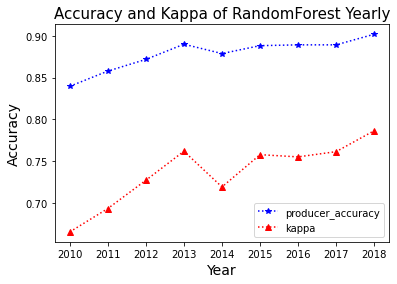

In [23]:
import matplotlib.pyplot as plt
import numpy as np
year = np.arange(2010,2019,1)
# plot permanent water and seasonal water(折线图)
plt.title("Accuracy and Kappa of RandomForest Yearly", fontsize=15)
plt.xlabel("Year", fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.plot(year,all_accuracy,'*:b' ,label = 'producer_accuracy')
plt.plot(year,kappa,'^:r',label='kappa')
plt.legend()
plt.show()